In [ ]:
!pip install ultralytics

In [ ]:
# YOLOv12n Edge Optimization Pipeline (Google Colab)
# Complete script: baseline training, distillation, pruning, quantization (PTQ/QAT), export (ONNX/TFLite)

# --- Step 0: Setup Colab environment ---
from google.colab import drive
import os, yaml, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.quantization import QuantStub, DeQuantStub
from ultralytics import YOLO
from ultralytics.nn.modules import Conv, Detect, Bottleneck
from ultralytics.models.yolo.detect import DetectionTrainer
import torch.nn.utils.prune as prune
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display
from ultralytics.utils.plotting import plot_results
from ultralytics.nn.tasks import DetectionModel


# Define paths
base_path = '/content/drive/My Drive/'
data_path = os.path.join(base_path, 'SemesterProjectDatas/CombinedData')
model_path = os.path.join(base_path, 'SemesterProjectDatas/Model/NewEnhancedYolo12nModule')
os.makedirs(model_path, exist_ok=True)
data_yaml = os.path.join(data_path, 'data.yaml')
base_model = 'yolo12n.pt'


# Load data yaml to get number of classes
with open(data_yaml, 'r') as f:
    data_dict = yaml.safe_load(f)
nc = data_dict['nc']

print(f"Loaded data.yaml with {nc} classes: {data_dict['names']}")

Loaded data.yaml with 11 classes: ['Tin', 'cardboard', 'cigarette-butts', 'food-wrappers-packaging', 'litter', 'mask', 'paper-items', 'plastic-bags', 'plastic-bottles-containers', 'small-packaging-trash', 'straw']


In [ ]:
# Load YOLO12n model
model = YOLO('yolo12n.pt')

# Create dummy input tensor
dummy_input = torch.randn(1, 3, 640, 640)

# Extract backbone layers (all but the last Detect layer)
layers = model.model.model[:-1]

# Forward pass through the backbone, correctly handling Concat layers
outputs = []
x = dummy_input
for layer in layers:
    if layer.f != -1:
        x = layer([outputs[i] for i in layer.f])
    else:
        x = layer(x)
    outputs.append(x)

# Last three outputs are backbone outputs (feature maps)
p3, p4, p5 = outputs[-3], outputs[-2], outputs[-1]

print("✅ Backbone Feature Maps:")
print(f"P3 shape: {p3.shape}")
print(f"P4 shape: {p4.shape}")
print(f"P5 shape: {p5.shape}")

# Inspect Detection Head configuration robustly
detect_layer = model.model.model[-1]

print("\n🔎 Detection Head Configuration:")
anchors = getattr(detect_layer, 'anchors', None)
print("Anchors:", anchors if anchors is not None else "Anchor-free")

strides = getattr(detect_layer, 'stride', None)
print("Strides:", strides.tolist() if strides is not None else "Not found")

nl = getattr(detect_layer, 'nl', len(strides) if strides is not None else "Unknown")
print("Number of detection layers (nl):", nl)

print(model)

✅ Backbone Feature Maps:
P3 shape: torch.Size([1, 128, 20, 20])
P4 shape: torch.Size([1, 384, 20, 20])
P5 shape: torch.Size([1, 256, 20, 20])

🔎 Detection Head Configuration:
Anchors: tensor([[ 0.5000,  1.5000,  2.5000,  ...,  8.5000,  9.5000, 10.5000],
        [ 0.5000,  0.5000,  0.5000,  ..., 20.5000, 20.5000, 20.5000]])
Strides: [8.0, 16.0, 32.0]
Number of detection layers (nl): 3
YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv

In [ ]:
# --- Enhanced YOLOv12n for Trash Detection (Non-Replacement Approach) ---

# Set up Colab environment and mount Google Drive
from google.colab import drive
import os
import yaml
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn.modules import Conv, Bottleneck, C3k2, DWConv, Detect, SPPF, A2C2f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image, display
from ultralytics.utils.plotting import plot_results


# =====================================
# PART 1: ENHANCEMENT MODULE DEFINITIONS
# =====================================

# 1. Convolutional Block Attention Module (CBAM)
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction_ratio, 1, bias=False),
            nn.SiLU(inplace=True),
            nn.Conv2d(channels // reduction_ratio, channels, 1, bias=False)
        )

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        return torch.sigmoid(out)

class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(channels, reduction_ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

# 2. Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4.):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)

        # Multi-head attention
        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)
        self.proj = nn.Linear(dim, dim)

        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.SiLU(inplace=True),
            nn.Linear(mlp_hidden_dim, dim)
        )

    def forward(self, x):
        B, C, H, W = x.shape

        # Reshape to sequence for transformer
        x_seq = x.flatten(2).transpose(1, 2)  # B, HW, C

        # Layer normalization and multi-head attention
        residual = x_seq
        x_ln = self.norm1(x_seq)

        # Split heads
        q = self.q(x_ln).reshape(B, H*W, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k(x_ln).reshape(B, H*W, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v(x_ln).reshape(B, H*W, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (C // self.num_heads) ** 0.5)
        attn = attn.softmax(dim=-1)

        # Apply attention
        x_attn = (attn @ v).permute(0, 2, 1, 3).reshape(B, H*W, C)
        x_attn = self.proj(x_attn)

        # First residual connection
        x_seq = residual + x_attn

        # Layer normalization and MLP
        residual = x_seq
        x_seq = self.norm2(x_seq)
        x_seq = self.mlp(x_seq)

        # Second residual connection
        x_seq = residual + x_seq

        # Reshape back to feature map
        x = x_seq.transpose(1, 2).reshape(B, C, H, W)

        return x

# 3. Small Object Features Enhancement
class SmallObjectFeatures(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = Conv(in_channels, in_channels, k=1)
        self.conv2 = Conv(in_channels, in_channels, k=3, g=in_channels)  # Depthwise
        self.conv3 = Conv(in_channels, out_channels, k=1)  # Pointwise
        self.cbam = CBAM(out_channels)

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x + shortcut  # Skip connection
        x = self.cbam(x)
        return x

# 4. BiFPN Fusion Node
class BiFPN_FusionNode(nn.Module):
    def __init__(self, in_channels_1, in_channels_2, out_channels):
        super().__init__()
        self.w1 = nn.Parameter(torch.ones(1, dtype=torch.float32))
        self.w2 = nn.Parameter(torch.ones(1, dtype=torch.float32))
        self.epsilon = 1e-4
        self.conv1 = Conv(in_channels_1, out_channels, k=1) if in_channels_1 != out_channels else nn.Identity()
        self.conv2 = Conv(in_channels_2, out_channels, k=1) if in_channels_2 != out_channels else nn.Identity()
        self.conv_fused = Conv(out_channels, out_channels, k=3)

    def forward(self, feature1, feature2):
        # Normalize weights
        w = torch.cat([self.w1, self.w2]).softmax(dim=0)

        # Process input features
        f1 = self.conv1(feature1)
        f2 = self.conv2(feature2)

        # Ensure feature maps have same dimensions
        if f1.shape[2:] != f2.shape[2:]:
            f2 = F.interpolate(f2, size=f1.shape[2:], mode='nearest')

        # Weighted fusion
        fused = (w[0] * f1 + w[1] * f2) / (w.sum() + self.epsilon)
        fused = self.conv_fused(fused)
        return fused

# =====================================
# PART 2: ENHANCE EXISTING YOLO MODEL
# =====================================

class EnhancedLayer(nn.Module):
    """Wrapper to enhance an existing layer with CBAM"""
    def __init__(self, original_layer, cbam):
        super().__init__()
        self.original_layer = original_layer
        self.cbam = cbam

    def forward(self, x):
        x = self.original_layer(x)
        x = self.cbam(x)
        return x

class TransformerLayer(nn.Module):
    """Wrapper to add transformer encoder to an existing layer"""
    def __init__(self, original_layer, transformer):
        super().__init__()
        self.original_layer = original_layer
        self.transformer = transformer

    def forward(self, x):
        x = self.original_layer(x)
        h, w = x.shape[2], x.shape[3]
        B, C = x.shape[0], x.shape[1]
        # Only apply transformer if dimensions are suitable
        if C >= 16 and h*w <= 4096:  # Avoid memory issues with large feature maps
            x = self.transformer(x)
        return x

class SOFLayer(nn.Module):
    """Wrapper to add small object features enhancement"""
    def __init__(self, original_layer, sof):
        super().__init__()
        self.original_layer = original_layer
        self.sof = sof

    def forward(self, x):
        x = self.original_layer(x)
        x = self.sof(x)
        return x

class EnhancedYOLOModel(nn.Module):
    """Enhances existing YOLO model without replacing internal layers"""
    def __init__(self, yolo_model):
        super().__init__()
        self.model = yolo_model
        self.enhanced = False

    def enhance_model(self):
        """Add enhancement modules to the existing model"""
        if self.enhanced:
            print("Model already enhanced")
            return

        # Get the PyTorch model
        model = self.model.model

        # Map of layer indices to their channel dimensions
        layer_info = {}

        # Identify important layers and their dimensions
        for i, m in enumerate(model.model):
            if isinstance(m, (C3k2, A2C2f)):
                # Assuming these blocks have attribute c2 for output channels
                if hasattr(m, 'c2'):
                    layer_info[i] = m.c2
                elif hasattr(m, 'cv2') and hasattr(m.cv2, 'conv') and hasattr(m.cv2.conv, 'out_channels'):
                    layer_info[i] = m.cv2.conv.out_channels

        print(f"Found {len(layer_info)} layers to enhance at indices: {list(layer_info.keys())}")

        # Enhance specific layers with CBAM
        cbam_indices = [4, 8, 14, 17]  # Example indices for CBAM enhancement
        for idx in cbam_indices:
            if idx in layer_info:
                channels = layer_info[idx]
                original_layer = model.model[idx]
                model.model[idx] = EnhancedLayer(original_layer, CBAM(channels))
                print(f"Added CBAM to layer {idx} with {channels} channels")

        # Add transformer to a deeper layer
        transformer_idx = 8  # Typically a deeper layer
        if transformer_idx in layer_info:
            channels = layer_info[transformer_idx]
            original_layer = model.model[transformer_idx]
            model.model[transformer_idx] = TransformerLayer(
                original_layer,
                TransformerEncoderBlock(channels, num_heads=max(1, channels // 32))
            )
            print(f"Added Transformer to layer {transformer_idx} with {channels} channels")

        # Add small object features enhancement to specific layers
        sof_indices = [11]  # FPN layer for small object enhancement
        for idx in sof_indices:
            if idx in layer_info:
                channels = layer_info[idx]
                original_layer = model.model[idx]
                model.model[idx] = SOFLayer(
                    original_layer,
                    SmallObjectFeatures(channels, channels)
                )
                print(f"Added Small Object Features to layer {idx} with {channels} channels")

        print("Model enhancement complete")
        self.enhanced = True

        return self.model

def enhance_yolo_model(yolo_model):
    """Enhance an existing YOLO model with advanced modules"""
    enhancer = EnhancedYOLOModel(yolo_model)
    return enhancer.enhance_model()



In [ ]:
# =====================================
# PART 3: TRAINING FUNCTION
# =====================================

def train_enhanced_yolo(data_yaml,
                       epochs=100,
                       batch_size=32,
                       img_size=640,
                       project_dir='/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule',
                       model_name='enhanced_yolov12n'):
    """
    Train an enhanced YOLO model without replacing internal layers

    Args:
        data_yaml: Path to data.yaml file
        epochs: Number of training epochs
        batch_size: Batch size
        img_size: Input image size
        project_dir: Output directory
        model_name: Name for saving the model

    Returns:
        Trained model and metrics
    """
    print(f"Starting training with enhanced YOLOv12n")
    print(f"Loading base model: {base_model}")

    # Load original YOLOv12n model
    original_model = YOLO(base_model)

    # Apply enhancements (without replacing internal layers)
    enhanced_model = enhance_yolo_model(original_model)

    # Create output directory
    os.makedirs(project_dir, exist_ok=True)

    # Train the enhanced model
    print(f"Starting training for {epochs} epochs...")
    results = original_model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=img_size,
        batch=batch_size,
        project=project_dir,
        name=model_name,
        exist_ok=True,
        device='cuda',
        patience=10,  # early stopping
        save=True,    # checkpoint saving
    )

    # Evaluate model
    print("\nTraining complete. Starting validation...")
    metrics = original_model.val(data=data_yaml)

    # Print results
    print("\n--- Final Model Performance ---")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP75: {metrics.box.map75:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")

    # Class-wise performance
    print("\n--- Per-Class Performance ---")
    for i, class_name in enumerate(data_dict['names']):
        print(f"{class_name}: AP = {metrics.box.maps[i]:.4f}")

    # Save detailed metrics to JSON
    metrics_dict = {
        'mAP50-95': float(metrics.box.map),
        'mAP50': float(metrics.box.map50),
        'mAP75': float(metrics.box.map75),
        'Mean_Precision': float(metrics.box.mp),
        'Mean_Recall': float(metrics.box.mr),
        'Per_class_AP': metrics.box.maps.tolist() if hasattr(metrics.box.maps, 'tolist') else list(metrics.box.maps),
        'Per_class_precision': metrics.box.p.tolist() if hasattr(metrics.box.p, 'tolist') else list(metrics.box.p),
        'Per_class_recall': metrics.box.r.tolist() if hasattr(metrics.box.r, 'tolist') else list(metrics.box.r),
        'F1_scores': metrics.box.f1.tolist() if hasattr(metrics.box.f1, 'tolist') else list(metrics.box.f1),
        'Inference_speed(ms)': {
            'preprocessing': float(metrics.speed.get('preprocess', 0)),
            'inference': float(metrics.speed.get('inference', 0)),
            'postprocessing': float(metrics.speed.get('postprocess', 0))
        } if isinstance(metrics.speed, dict) else float(metrics.speed)
    }

    # Save metrics to JSON
    output_path = os.path.join(project_dir, model_name, 'metrics.json')
    with open(output_path, 'w') as f:
        json.dump(metrics_dict, f, indent=4)
    print(f"Metrics saved to {output_path}")

    # Plot results using YOLO plotting utilities
    csv_path = os.path.join(project_dir, model_name, 'results.csv')

    if os.path.exists(csv_path):
        print("Generating performance plots...")

        # Use YOLO's built-in plotting function
        try:
            plot_results(file=csv_path)
            plt.savefig(os.path.join(project_dir, model_name, 'training_metrics.png'), dpi=300)
            plt.show()
        except Exception as e:
            print(f"Error plotting results with plot_results: {e}")

        # Custom plots from CSV
        try:
            df = pd.read_csv(csv_path)
            df.columns = df.columns.str.strip()

            # Create 2x2 plot grid with losses and metrics
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))

            # Box loss
            if 'train/box_loss' in df.columns:
                axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Box Loss', color='blue')
                axes[0, 0].set_title('Training Box Loss')
                axes[0, 0].set_xlabel('Epoch')
                axes[0, 0].set_ylabel('Loss')
                axes[0, 0].legend()
                axes[0, 0].grid(True)

            # Classification loss
            if 'train/cls_loss' in df.columns:
                axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Classification Loss', color='orange')
                axes[0, 1].set_title('Training Classification Loss')
                axes[0, 1].set_xlabel('Epoch')
                axes[0, 1].set_ylabel('Loss')
                axes[0, 1].legend()
                axes[0, 1].grid(True)

            # DFL loss
            if 'train/dfl_loss' in df.columns:
                axes[1, 0].plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss', color='green')
                axes[1, 0].set_title('Training DFL Loss')
                axes[1, 0].set_xlabel('Epoch')
                axes[1, 0].set_ylabel('Loss')
                axes[1, 0].legend()
                axes[1, 0].grid(True)

            # mAP metrics
            if 'metrics/mAP50(B)' in df.columns and 'metrics/mAP50-95(B)' in df.columns:
                axes[1, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50', color='red')
                axes[1, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95', color='purple')
                axes[1, 1].set_title('Validation mAP')
                axes[1, 1].set_xlabel('Epoch')
                axes[1, 1].set_ylabel('mAP')
                axes[1, 1].legend()
                axes[1, 1].grid(True)

            plt.tight_layout()
            plt.savefig(os.path.join(project_dir, model_name, 'loss_plots.png'), dpi=300)
            plt.show()

            # Combined loss plot
            plt.figure(figsize=(12, 8))
            if 'train/box_loss' in df.columns:
                plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss', linewidth=2)
            if 'train/cls_loss' in df.columns:
                plt.plot(df['epoch'], df['train/cls_loss'], label='Classification Loss', linewidth=2)
            if 'train/dfl_loss' in df.columns:
                plt.plot(df['epoch'], df['train/dfl_loss'], label='DFL Loss', linewidth=2)
            plt.title('Training Losses over Epochs', fontsize=16)
            plt.xlabel('Epoch', fontsize=14)
            plt.ylabel('Loss', fontsize=14)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.savefig(os.path.join(project_dir, model_name, 'combined_losses.png'), dpi=300)
            plt.show()

        except Exception as e:
            print(f"Error generating custom plots: {e}")

        # Display YOLO-generated plots that exist
        print("\nShowing additional YOLO-generated plots:")
        plots = ['results.png', 'confusion_matrix.png', 'labels.jpg', 'PR_curve.png', 'F1_curve.png']
        plot_dir = os.path.join(project_dir, model_name)

        for plot in plots:
            plot_path = os.path.join(plot_dir, plot)
            if os.path.exists(plot_path):
                print(f"Displaying {plot}")
                display(Image(filename=plot_path))
            else:
                print(f"{plot} not found")
    else:
        print(f"Results CSV not found at {csv_path}")

    return original_model, metrics


Enhanced YOLOv12n for Trash Detection - Non-Replacement Approach
Starting training with enhanced YOLOv12n
Loading base model: yolo12n.pt
Found 8 layers to enhance at indices: [2, 4, 6, 8, 11, 14, 17, 20]
Added CBAM to layer 4 with 128 channels
Added CBAM to layer 8 with 256 channels
Added CBAM to layer 14 with 64 channels
Added CBAM to layer 17 with 128 channels
Added Transformer to layer 8 with 256 channels
Added Small Object Features to layer 11 with 128 channels
Model enhancement complete
Starting training for 100 epochs...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/SemesterProjectDatas/CombinedData/data.yaml, degrees=0.0, deterministic=True, device=0, df

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]

Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytic

YOLOv12n summary: 272 layers, 2,570,193 parameters, 2,570,177 gradients, 6.5 GFLOPs

Transferred 322/691 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 64.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 33.0±62.6 ms, read: 0.1±0.0 MB/s, size: 63.4 KB)


train: Scanning /content/drive/MyDrive/SemesterProjectDatas/CombinedData/train/labels.cache... 6527 images, 1141 backgrounds, 0 corrupt: 100%|██████████| 6527/6527 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 9723, len(boxes) = 30435. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 0.3±0.1 MB/s, size: 108.3 KB)


val: Scanning /content/drive/MyDrive/SemesterProjectDatas/CombinedData/valid/labels.cache... 591 images, 96 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 937, len(boxes) = 2808. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.36G      3.331      6.353      2.487        198        640: 100%|██████████| 204/204 [09:59<00:00,  2.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


                   all        591       2808   0.000137   0.000909   6.37e-05   4.46e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       9.2G       2.96      5.554      2.021        158        640: 100%|██████████| 204/204 [00:40<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


                   all        591       2808      0.588    0.00673    0.00506    0.00159

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      9.21G      2.611      4.413       1.67        127        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


                   all        591       2808      0.133     0.0479      0.012    0.00545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      9.22G      2.519      3.847      1.613        198        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


                   all        591       2808      0.307     0.0727      0.015    0.00592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.23G      2.381      3.523      1.527        153        640: 100%|██████████| 204/204 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


                   all        591       2808      0.338     0.0977      0.026     0.0131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      9.23G      2.322      3.412      1.512        180        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.64it/s]


                   all        591       2808      0.343     0.0753     0.0317     0.0169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      9.23G      2.272      3.341      1.489        197        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        591       2808      0.353      0.115     0.0409     0.0209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      9.23G      2.224      3.244      1.467        184        640: 100%|██████████| 204/204 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


                   all        591       2808      0.436      0.103     0.0366     0.0177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      9.23G      2.185      3.189      1.455        131        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        591       2808      0.364      0.117     0.0437     0.0231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      9.23G      2.164      3.129      1.427        170        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


                   all        591       2808      0.348      0.126     0.0451     0.0234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      9.23G      2.139      3.079      1.432        207        640: 100%|██████████| 204/204 [00:39<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        591       2808      0.342      0.104     0.0445      0.024

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      9.23G      2.138      3.055      1.411        208        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


                   all        591       2808      0.357      0.132     0.0491     0.0258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.23G      2.114      3.037      1.408        156        640: 100%|██████████| 204/204 [00:39<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        591       2808      0.365       0.12     0.0519     0.0271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      9.23G      2.081      2.983      1.384        188        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        591       2808      0.369      0.113     0.0522     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.23G      2.075      2.973      1.381        135        640: 100%|██████████| 204/204 [00:39<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        591       2808      0.378      0.149     0.0562      0.031

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      9.23G      2.058      2.927      1.374        249        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        591       2808      0.366       0.13     0.0596     0.0318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      9.23G      2.057      2.926      1.379        214        640: 100%|██████████| 204/204 [00:38<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        591       2808      0.364      0.137     0.0538     0.0289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      9.23G      2.043      2.896      1.369        205        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


                   all        591       2808      0.377      0.143     0.0608     0.0333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      9.23G      2.026       2.87      1.363        153        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        591       2808      0.296      0.149     0.0683     0.0364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      9.23G      2.021      2.834      1.359        188        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


                   all        591       2808      0.305      0.158     0.0657      0.037

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      9.23G      2.012      2.826      1.359        109        640: 100%|██████████| 204/204 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        591       2808      0.286      0.155      0.061     0.0318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      9.23G      1.998      2.817      1.335        184        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        591       2808      0.292      0.157     0.0718     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      9.23G      2.014      2.817      1.344        217        640: 100%|██████████| 204/204 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        591       2808      0.287      0.154     0.0662     0.0365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      9.23G      1.971      2.783      1.335        222        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


                   all        591       2808      0.293      0.154     0.0695     0.0373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      9.23G       1.98      2.751      1.326        230        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        591       2808      0.285      0.161     0.0756     0.0415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      9.23G      1.971      2.726      1.316        196        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        591       2808      0.268      0.168     0.0788     0.0426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      9.23G      1.952      2.704      1.312        205        640: 100%|██████████| 204/204 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]

                   all        591       2808      0.285      0.159     0.0745     0.0398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      9.23G      1.962      2.722      1.318        186        640: 100%|██████████| 204/204 [00:39<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


                   all        591       2808      0.294      0.161     0.0781     0.0439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.23G      1.952      2.704      1.314        231        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


                   all        591       2808       0.31      0.165     0.0826     0.0448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      9.23G       1.94      2.683        1.3        155        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


                   all        591       2808      0.321      0.186     0.0842     0.0458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      9.23G      1.935       2.67      1.304        203        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        591       2808        0.3      0.184     0.0778     0.0442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.23G      1.928       2.66      1.299        154        640: 100%|██████████| 204/204 [00:39<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.61it/s]


                   all        591       2808      0.287      0.179     0.0755     0.0415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.23G      1.941      2.665      1.294        193        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        591       2808      0.211      0.173     0.0753     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      9.23G      1.928      2.639      1.289        182        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        591       2808      0.307      0.173     0.0835     0.0488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      9.23G      1.922      2.639      1.291        199        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


                   all        591       2808      0.305      0.182      0.085     0.0478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      9.23G      1.903      2.595      1.284        227        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


                   all        591       2808      0.236      0.186     0.0905     0.0517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      9.23G      1.909      2.596      1.284        282        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        591       2808      0.208      0.191     0.0864      0.051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.23G       1.91      2.565      1.274        166        640: 100%|██████████| 204/204 [00:39<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        591       2808      0.334      0.169     0.0901     0.0516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      9.23G      1.922      2.599      1.285        212        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


                   all        591       2808      0.302      0.184     0.0916     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      9.23G      1.925      2.558      1.276        188        640: 100%|██████████| 204/204 [00:39<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        591       2808       0.33      0.177     0.0936     0.0529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      9.23G      1.886      2.544      1.269        162        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.91it/s]


                   all        591       2808      0.235      0.198     0.0982     0.0547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      9.23G      1.897      2.562      1.267        127        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        591       2808       0.29      0.196      0.101     0.0565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      9.23G      1.897      2.522      1.272        232        640: 100%|██████████| 204/204 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        591       2808      0.243      0.214      0.101     0.0576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      9.23G      1.892      2.496      1.253        150        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


                   all        591       2808      0.258      0.208     0.0979     0.0552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      9.23G      1.871       2.49      1.254        206        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        591       2808      0.242      0.188      0.101     0.0578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      9.23G      1.882      2.499      1.266        148        640: 100%|██████████| 204/204 [00:39<00:00,  5.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


                   all        591       2808      0.271       0.19      0.105     0.0598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      9.23G      1.891      2.497       1.27        170        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        591       2808      0.252      0.197      0.113     0.0661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      9.23G      1.894      2.484      1.254        109        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        591       2808      0.243      0.192      0.104     0.0598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      9.23G      1.858      2.462      1.248        171        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


                   all        591       2808      0.347      0.193      0.114     0.0655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      9.23G      1.869      2.442      1.254        194        640: 100%|██████████| 204/204 [00:39<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]


                   all        591       2808      0.354      0.195      0.117     0.0695

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      9.23G      1.851      2.454      1.249        119        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        591       2808      0.347      0.207      0.116     0.0661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.23G      1.877       2.43      1.257        179        640: 100%|██████████| 204/204 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        591       2808      0.293      0.222      0.122     0.0718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      9.23G      1.854      2.414      1.243        171        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        591       2808      0.286      0.243      0.119     0.0675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      9.23G      1.851      2.396      1.246        189        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.02it/s]

                   all        591       2808      0.261      0.215       0.12     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      9.23G      1.876      2.395       1.24        191        640: 100%|██████████| 204/204 [00:39<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        591       2808      0.294       0.22      0.129     0.0738

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      9.23G      1.829      2.378      1.236         96        640: 100%|██████████| 204/204 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


                   all        591       2808      0.277      0.231      0.124      0.073

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      9.23G      1.848      2.378      1.239        172        640: 100%|██████████| 204/204 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        591       2808      0.269      0.229      0.126     0.0703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      9.23G       1.85      2.374      1.238        261        640: 100%|██████████| 204/204 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        591       2808      0.329      0.221      0.126     0.0719

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      9.23G       1.85      2.371      1.236        101        640: 100%|██████████| 204/204 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


                   all        591       2808      0.295      0.221      0.123     0.0716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      9.23G      1.824      2.346      1.238        273        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


                   all        591       2808      0.288      0.228      0.127     0.0735

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      9.23G      1.836      2.338      1.232        158        640: 100%|██████████| 204/204 [00:38<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]

                   all        591       2808       0.32      0.207      0.138     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      9.23G      1.821      2.318       1.22        184        640: 100%|██████████| 204/204 [00:39<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


                   all        591       2808      0.347       0.22      0.134     0.0772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      9.23G      1.836      2.352      1.229        155        640: 100%|██████████| 204/204 [00:38<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        591       2808      0.288      0.242      0.134     0.0758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      9.23G      1.818      2.302      1.229        199        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

                   all        591       2808      0.376      0.223      0.136     0.0795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      9.23G      1.828      2.283      1.219        268        640: 100%|██████████| 204/204 [00:38<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


                   all        591       2808      0.308      0.239      0.134     0.0753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      9.23G      1.817      2.275       1.23        134        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        591       2808       0.31       0.21      0.127     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      9.23G      1.805      2.259      1.213        203        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


                   all        591       2808      0.298      0.238       0.14     0.0809

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.23G      1.811       2.28      1.219        154        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        591       2808      0.301      0.229      0.137     0.0784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      9.23G      1.796      2.252      1.214        149        640: 100%|██████████| 204/204 [00:39<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

                   all        591       2808      0.318      0.231       0.14      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.23G      1.819      2.254      1.211        155        640: 100%|██████████| 204/204 [00:38<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        591       2808      0.303      0.244      0.138     0.0795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      9.23G      1.799      2.224      1.211        135        640: 100%|██████████| 204/204 [00:39<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        591       2808       0.32      0.252      0.149     0.0864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      9.23G      1.797      2.217      1.195        231        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


                   all        591       2808      0.307      0.246      0.144      0.082

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      9.23G      1.802      2.213      1.202        237        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.76it/s]


                   all        591       2808      0.338       0.23      0.149     0.0856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      9.23G      1.796      2.191      1.204        179        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        591       2808      0.335      0.237      0.153     0.0875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      9.23G      1.782      2.185        1.2        289        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        591       2808      0.307      0.251      0.154     0.0904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      9.23G      1.796        2.2      1.205        168        640: 100%|██████████| 204/204 [00:38<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.74it/s]

                   all        591       2808      0.325      0.212       0.15     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      9.23G      1.787      2.175      1.203        291        640: 100%|██████████| 204/204 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        591       2808      0.314      0.238      0.148     0.0842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      9.23G      1.776      2.162      1.198        225        640: 100%|██████████| 204/204 [00:38<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

                   all        591       2808      0.295      0.247      0.148     0.0855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.23G      1.783      2.154      1.204        132        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


                   all        591       2808      0.319      0.234      0.155     0.0905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.23G      1.771      2.135      1.191        121        640: 100%|██████████| 204/204 [00:38<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


                   all        591       2808      0.314      0.242      0.156     0.0904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      9.23G      1.757      2.123      1.192        108        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


                   all        591       2808      0.334      0.253      0.157     0.0913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      9.23G      1.771      2.138      1.198        174        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

                   all        591       2808      0.313      0.254      0.154     0.0892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      9.23G      1.767       2.11       1.19        210        640: 100%|██████████| 204/204 [00:38<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


                   all        591       2808       0.31      0.235      0.154     0.0902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      9.23G      1.775      2.108      1.196        142        640: 100%|██████████| 204/204 [00:39<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


                   all        591       2808      0.306      0.262      0.158      0.091

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      9.23G      1.752      2.092      1.184        154        640: 100%|██████████| 204/204 [00:39<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        591       2808      0.302      0.247      0.155     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      9.23G      1.762      2.075       1.19        175        640: 100%|██████████| 204/204 [00:38<00:00,  5.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


                   all        591       2808      0.332      0.226      0.155     0.0902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      9.23G       1.75      2.094      1.184        158        640: 100%|██████████| 204/204 [00:38<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.87it/s]

                   all        591       2808      0.308      0.245      0.155      0.091



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      9.23G       1.74      2.072      1.179        117        640: 100%|██████████| 204/204 [00:39<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

                   all        591       2808      0.308      0.272      0.158     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      9.23G      1.753      2.059      1.185        258        640: 100%|██████████| 204/204 [00:38<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.97it/s]

                   all        591       2808      0.311       0.27      0.159     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.23G      1.737      2.035      1.179        171        640: 100%|██████████| 204/204 [00:39<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.84it/s]

                   all        591       2808      0.319      0.249      0.158     0.0915


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.23G       1.76          2      1.183         96        640: 100%|██████████| 204/204 [00:40<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


                   all        591       2808      0.316      0.249      0.159     0.0941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.23G      1.743      1.942      1.167         75        640: 100%|██████████| 204/204 [00:38<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


                   all        591       2808      0.308       0.25      0.159      0.092

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      9.23G      1.727      1.932      1.167        141        640: 100%|██████████| 204/204 [00:38<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

                   all        591       2808      0.313      0.257      0.162     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      9.23G      1.721      1.911      1.164        126        640: 100%|██████████| 204/204 [00:38<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


                   all        591       2808      0.318      0.234      0.158     0.0918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      9.23G      1.722      1.888      1.164        152        640: 100%|██████████| 204/204 [00:38<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        591       2808      0.324      0.248      0.163     0.0938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      9.23G      1.716      1.878      1.164        109        640: 100%|██████████| 204/204 [00:38<00:00,  5.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


                   all        591       2808      0.317      0.242      0.162     0.0928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.23G      1.706      1.851      1.159        216        640: 100%|██████████| 204/204 [00:38<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

                   all        591       2808      0.315       0.25      0.161     0.0926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      9.23G       1.71      1.866      1.164         99        640: 100%|██████████| 204/204 [00:38<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.00it/s]

                   all        591       2808      0.316      0.254       0.16     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      9.23G      1.709      1.841      1.158        128        640: 100%|██████████| 204/204 [00:38<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


                   all        591       2808      0.315      0.252       0.16     0.0924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      9.23G      1.706      1.827      1.164        114        640: 100%|██████████| 204/204 [00:38<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


                   all        591       2808      0.313      0.254      0.159      0.092

100 epochs completed in 1.325 hours.
Optimizer stripped from /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n/weights/last.pt, 5.5MB
Optimizer stripped from /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n/weights/best.pt, 5.5MB

Validating /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n/weights/best.pt...
Ultralytics 8.3.135 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12n summary (fused): 159 layers, 2,558,873 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


                   all        591       2808      0.325      0.251      0.163     0.0936
                   Tin         43        100      0.337       0.35      0.251      0.176
             cardboard         69        102      0.214      0.225      0.119     0.0717
       cigarette-butts         63        405      0.459     0.0754      0.134     0.0396
food-wrappers-packaging        123        214      0.276      0.407      0.236      0.148
                litter        289       1640      0.291      0.318      0.213     0.0796
                  mask          1          1          1          0     0.0284     0.0114
           paper-items         40        112      0.183      0.152     0.0953     0.0454
          plastic-bags         25         32      0.172      0.312      0.173     0.0943
plastic-bottles-containers         91        119      0.258      0.454      0.299      0.217
 small-packaging-trash         55         61      0.289      0.328      0.216      0.134
                

val: Scanning /content/drive/MyDrive/SemesterProjectDatas/CombinedData/valid/labels.cache... 591 images, 96 backgrounds, 0 corrupt: 100%|██████████| 591/591 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 937, len(boxes) = 2808. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.72it/s]


                   all        591       2808      0.327       0.25      0.163     0.0943
                   Tin         43        100      0.337       0.35      0.251      0.179
             cardboard         69        102      0.208      0.216      0.119     0.0726
       cigarette-butts         63        405      0.479     0.0741      0.137     0.0396
food-wrappers-packaging        123        214      0.277      0.407      0.236      0.148
                litter        289       1640      0.298      0.321      0.215     0.0811
                  mask          1          1          1          0     0.0284     0.0114
           paper-items         40        112      0.184      0.152     0.0957     0.0452
          plastic-bags         25         32      0.174      0.312      0.173     0.0964
plastic-bottles-containers         91        119      0.259      0.454      0.299      0.219
 small-packaging-trash         55         61       0.29      0.328      0.215      0.133
                

<Figure size 640x480 with 0 Axes>

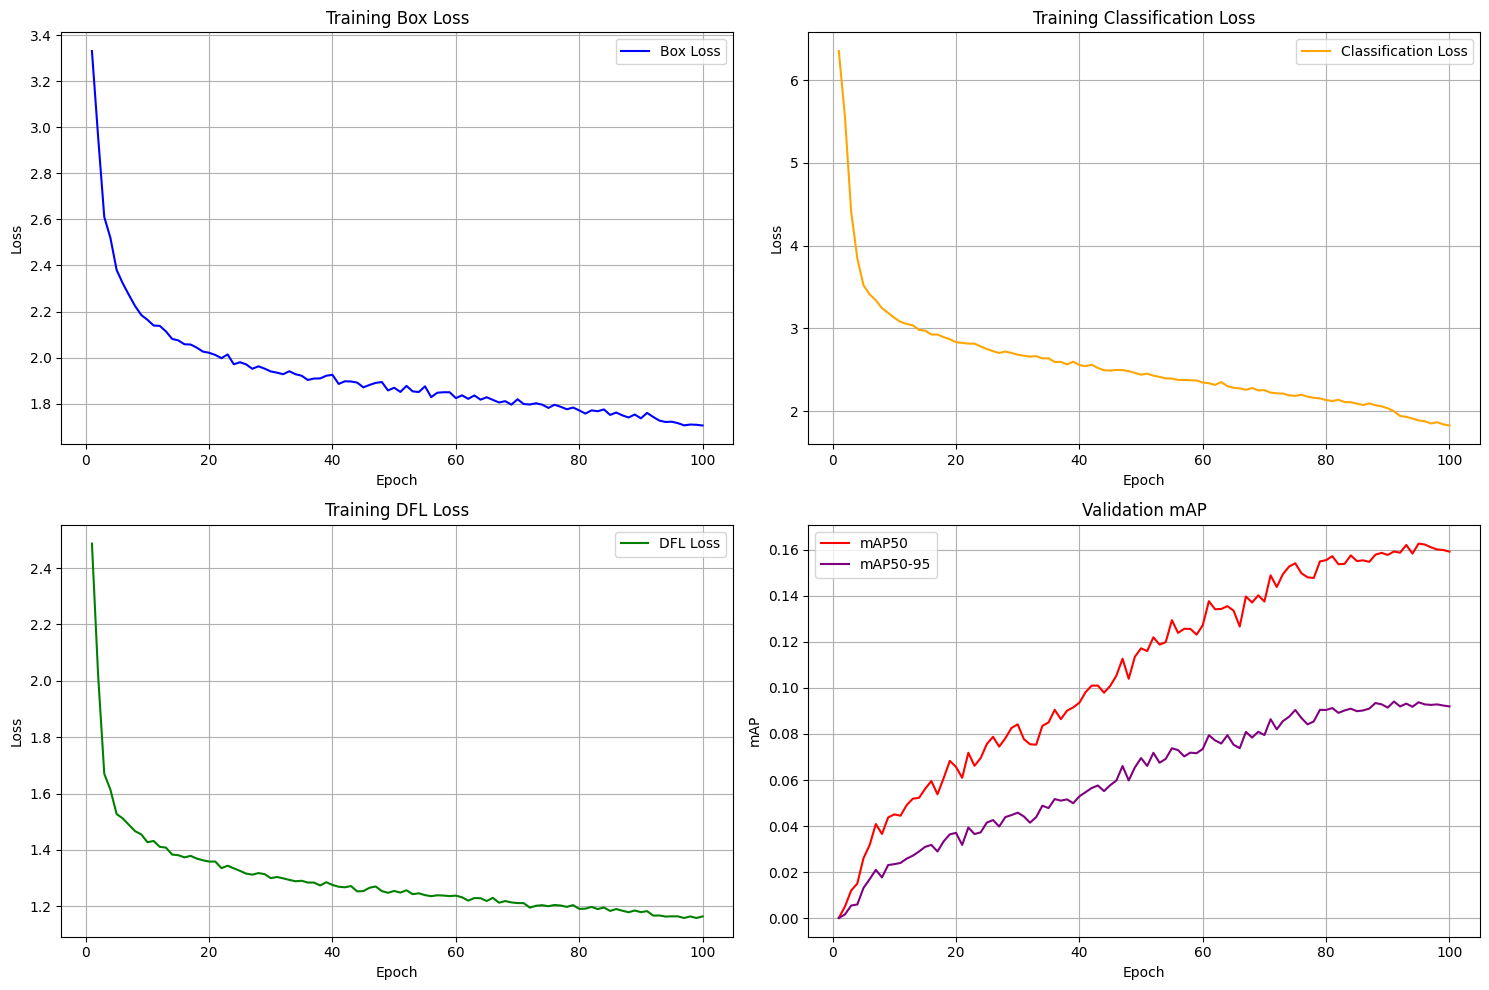

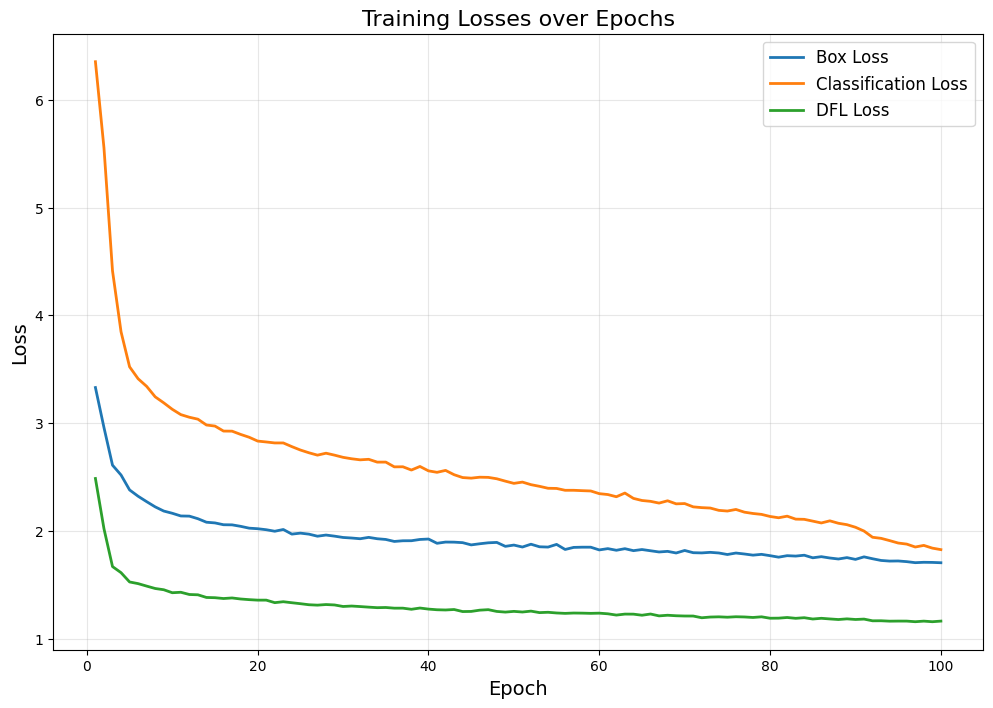


Showing additional YOLO-generated plots:
Displaying results.png


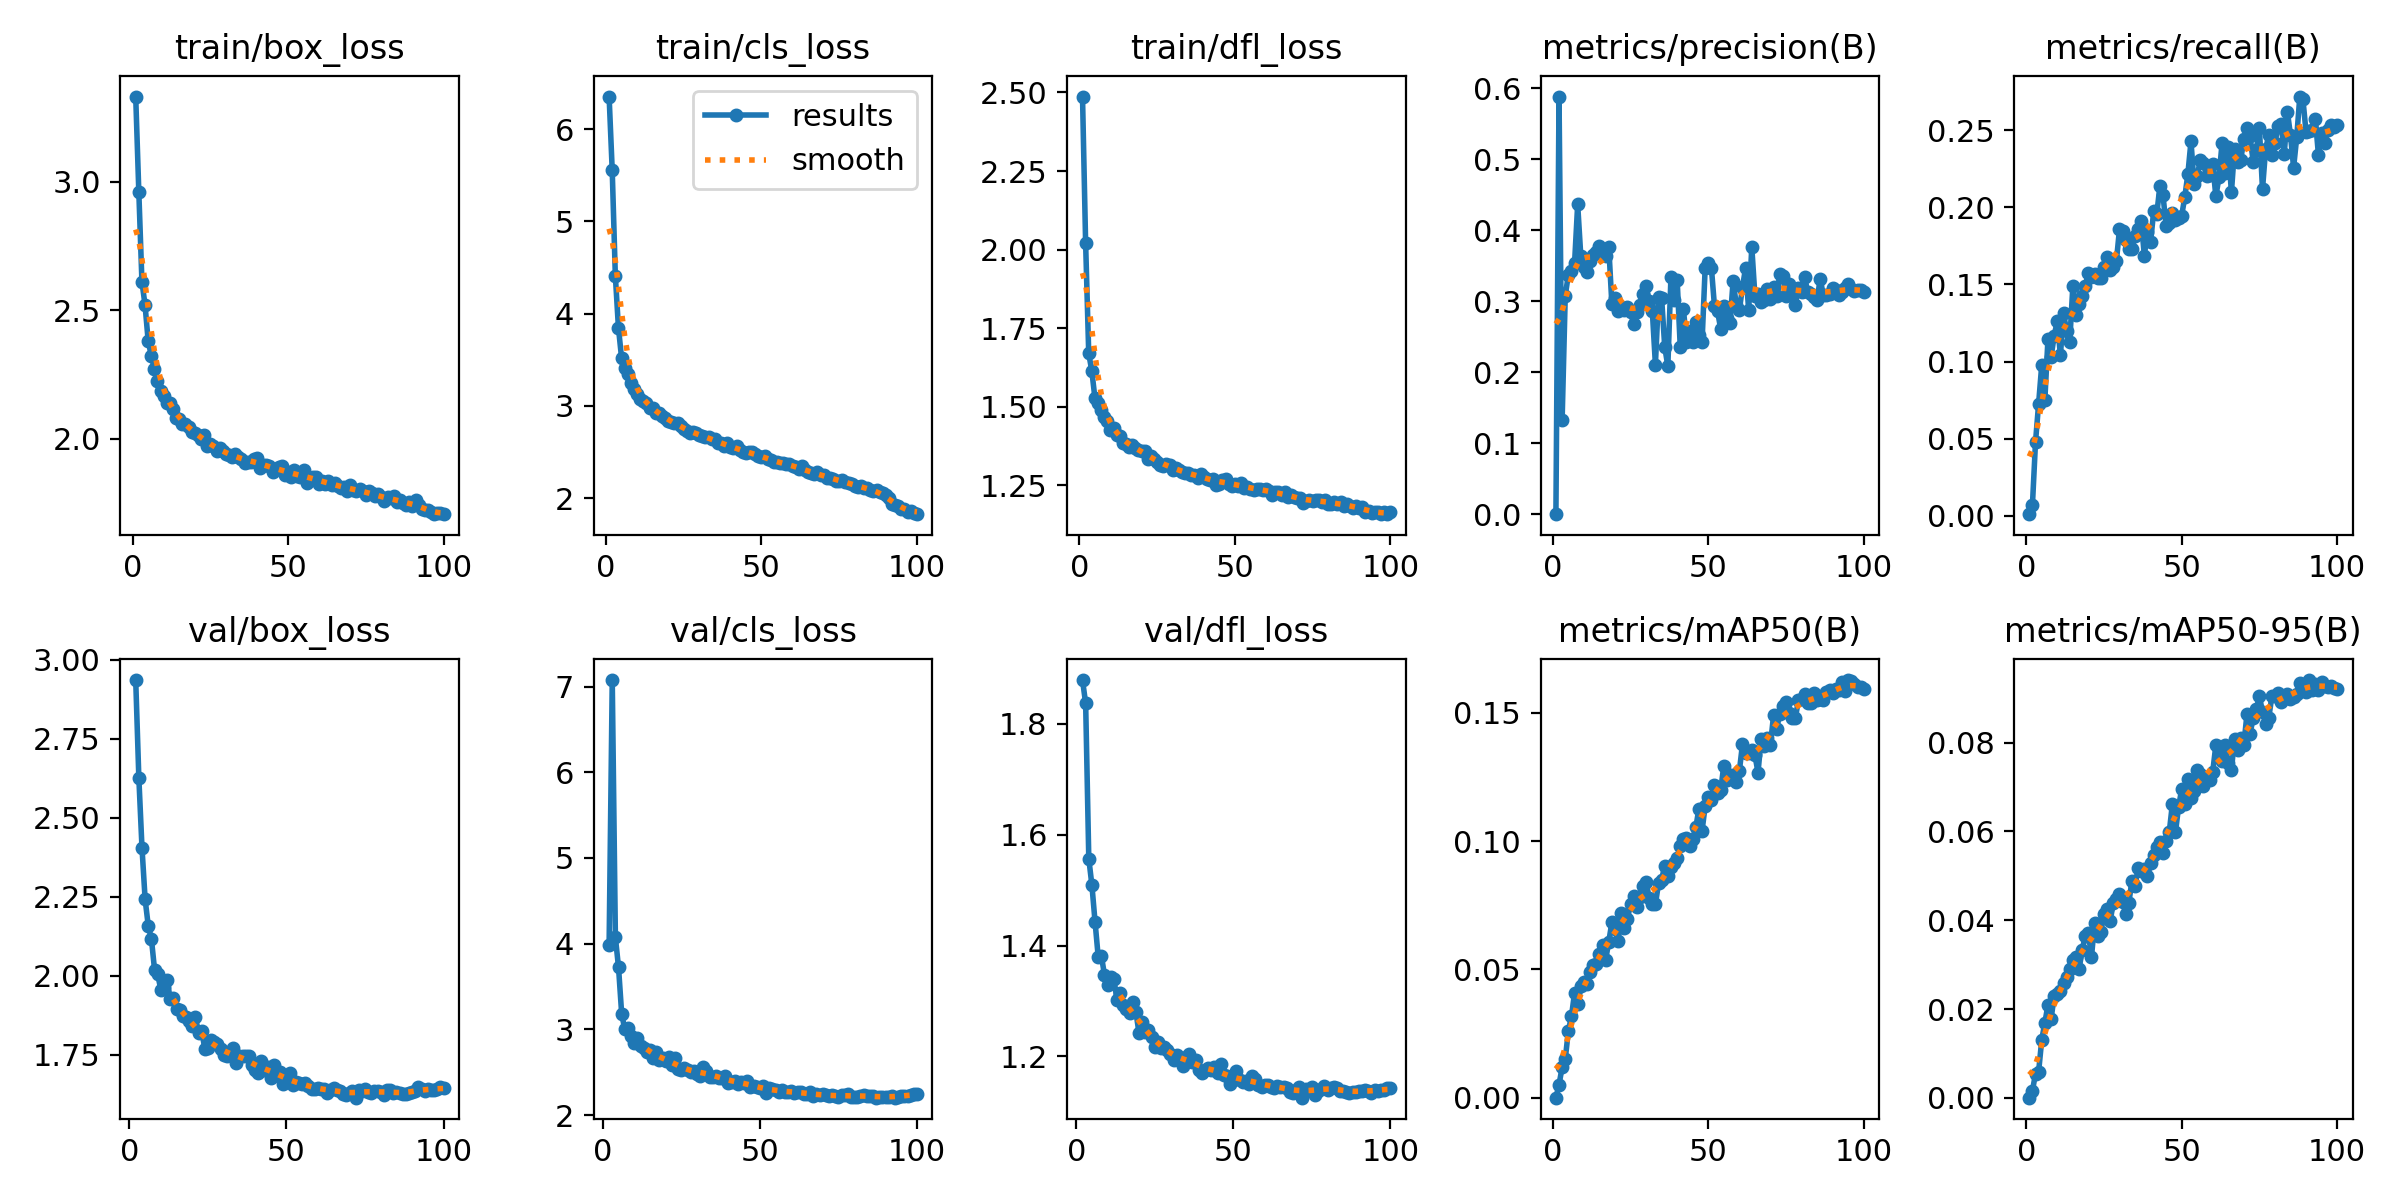

Displaying confusion_matrix.png


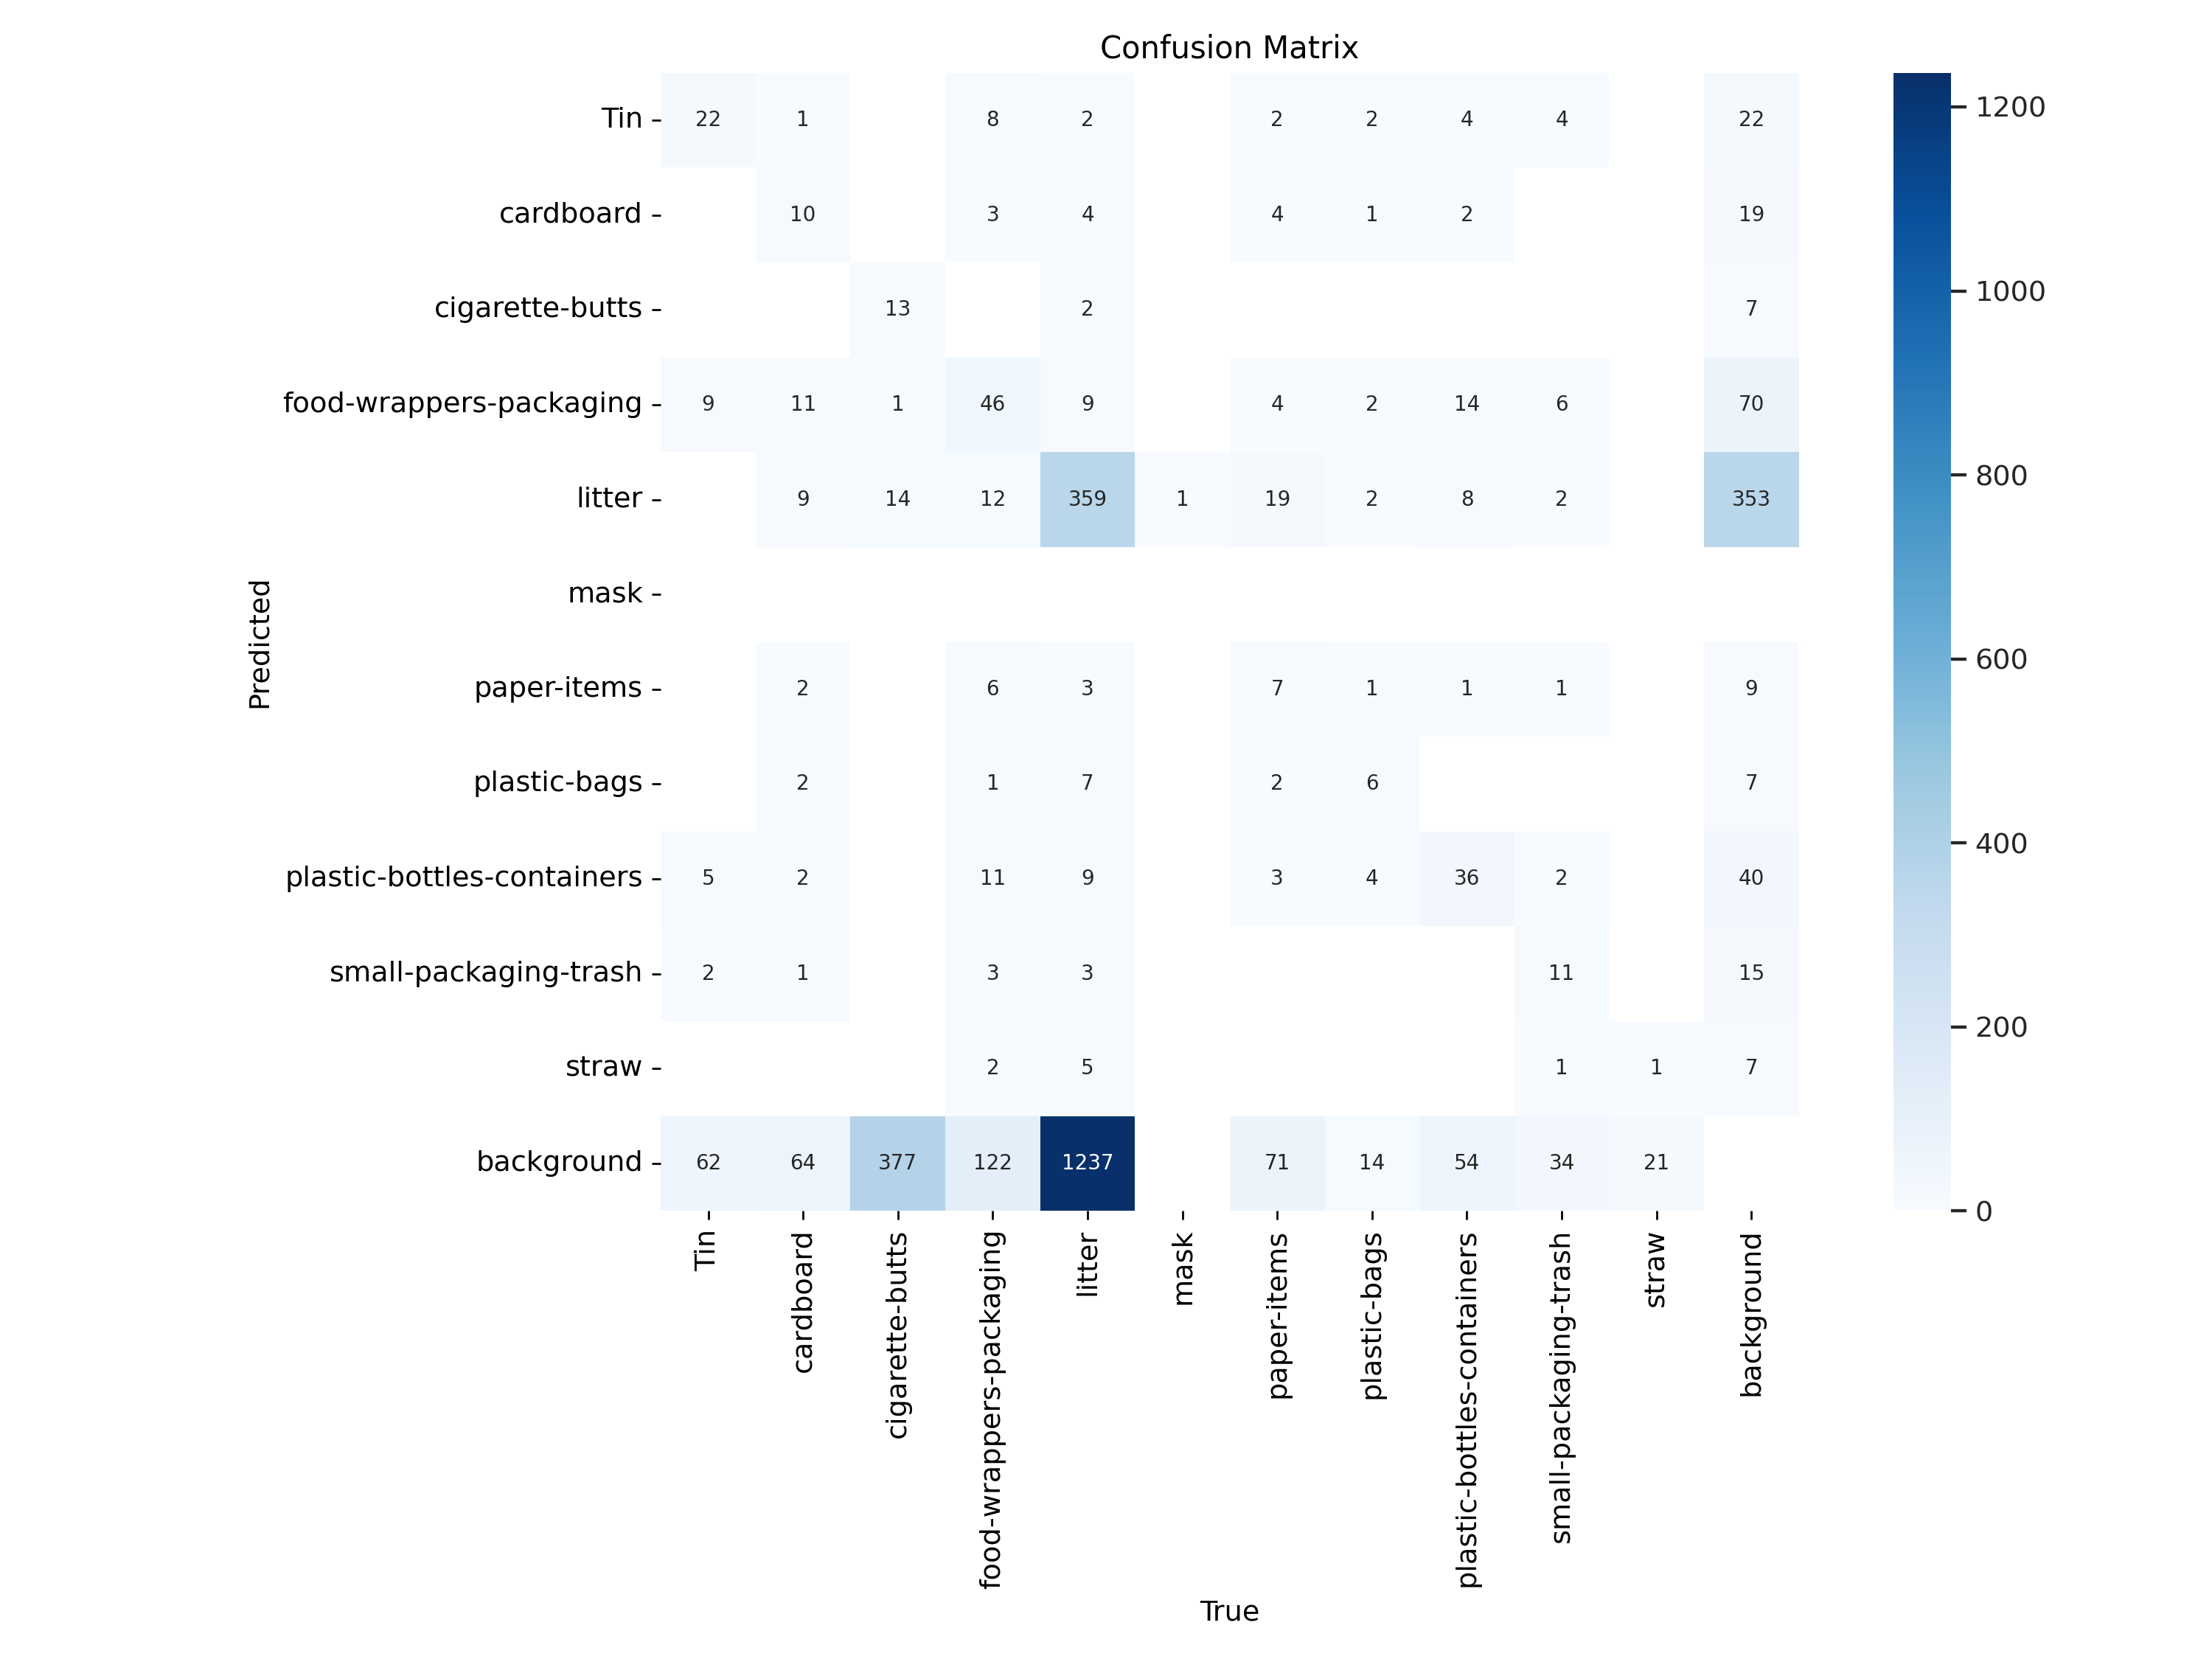

Displaying labels.jpg


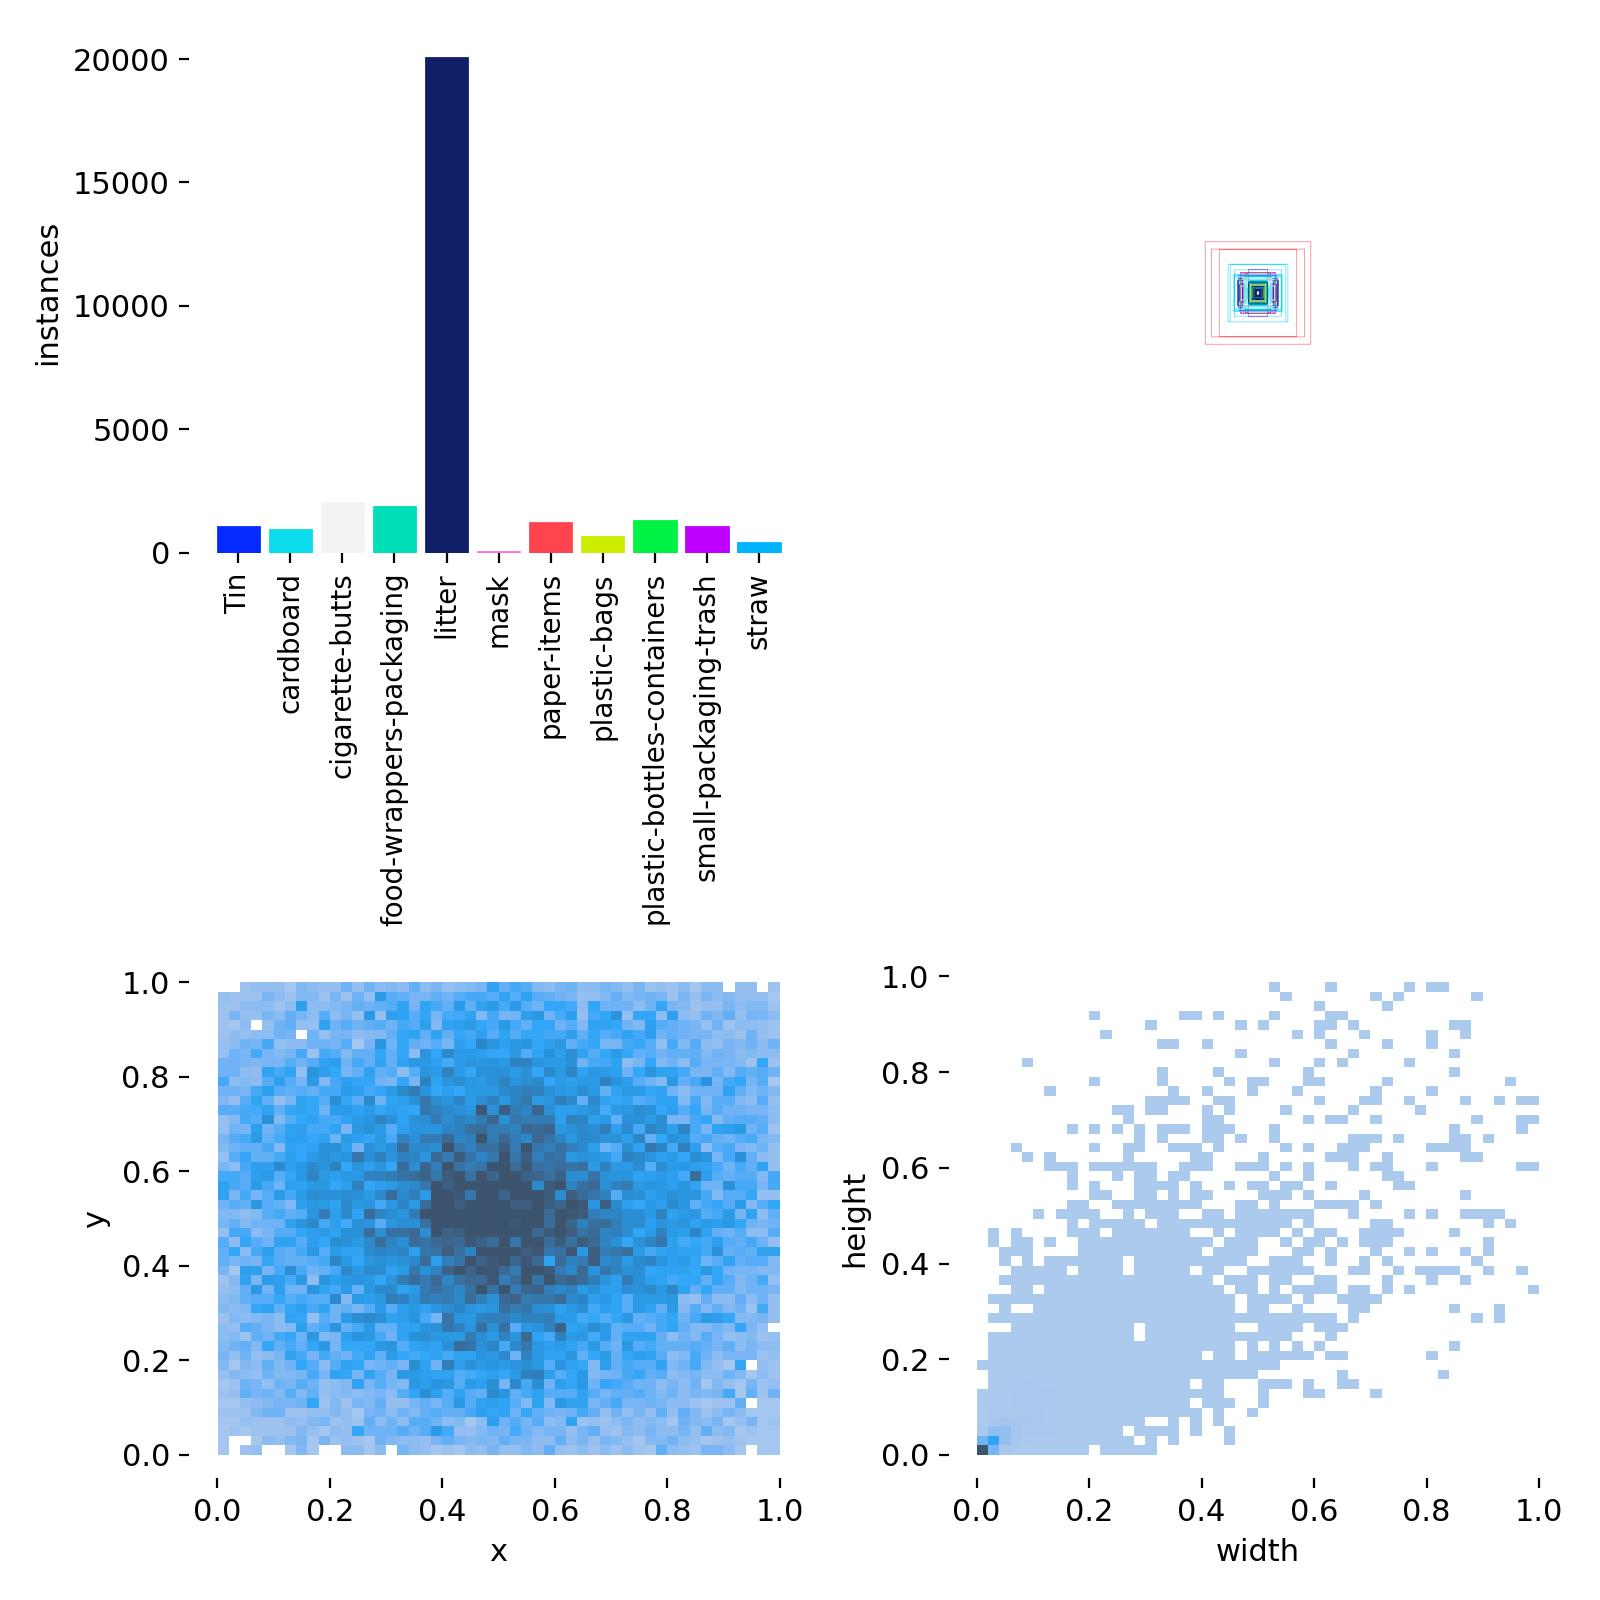

Displaying PR_curve.png


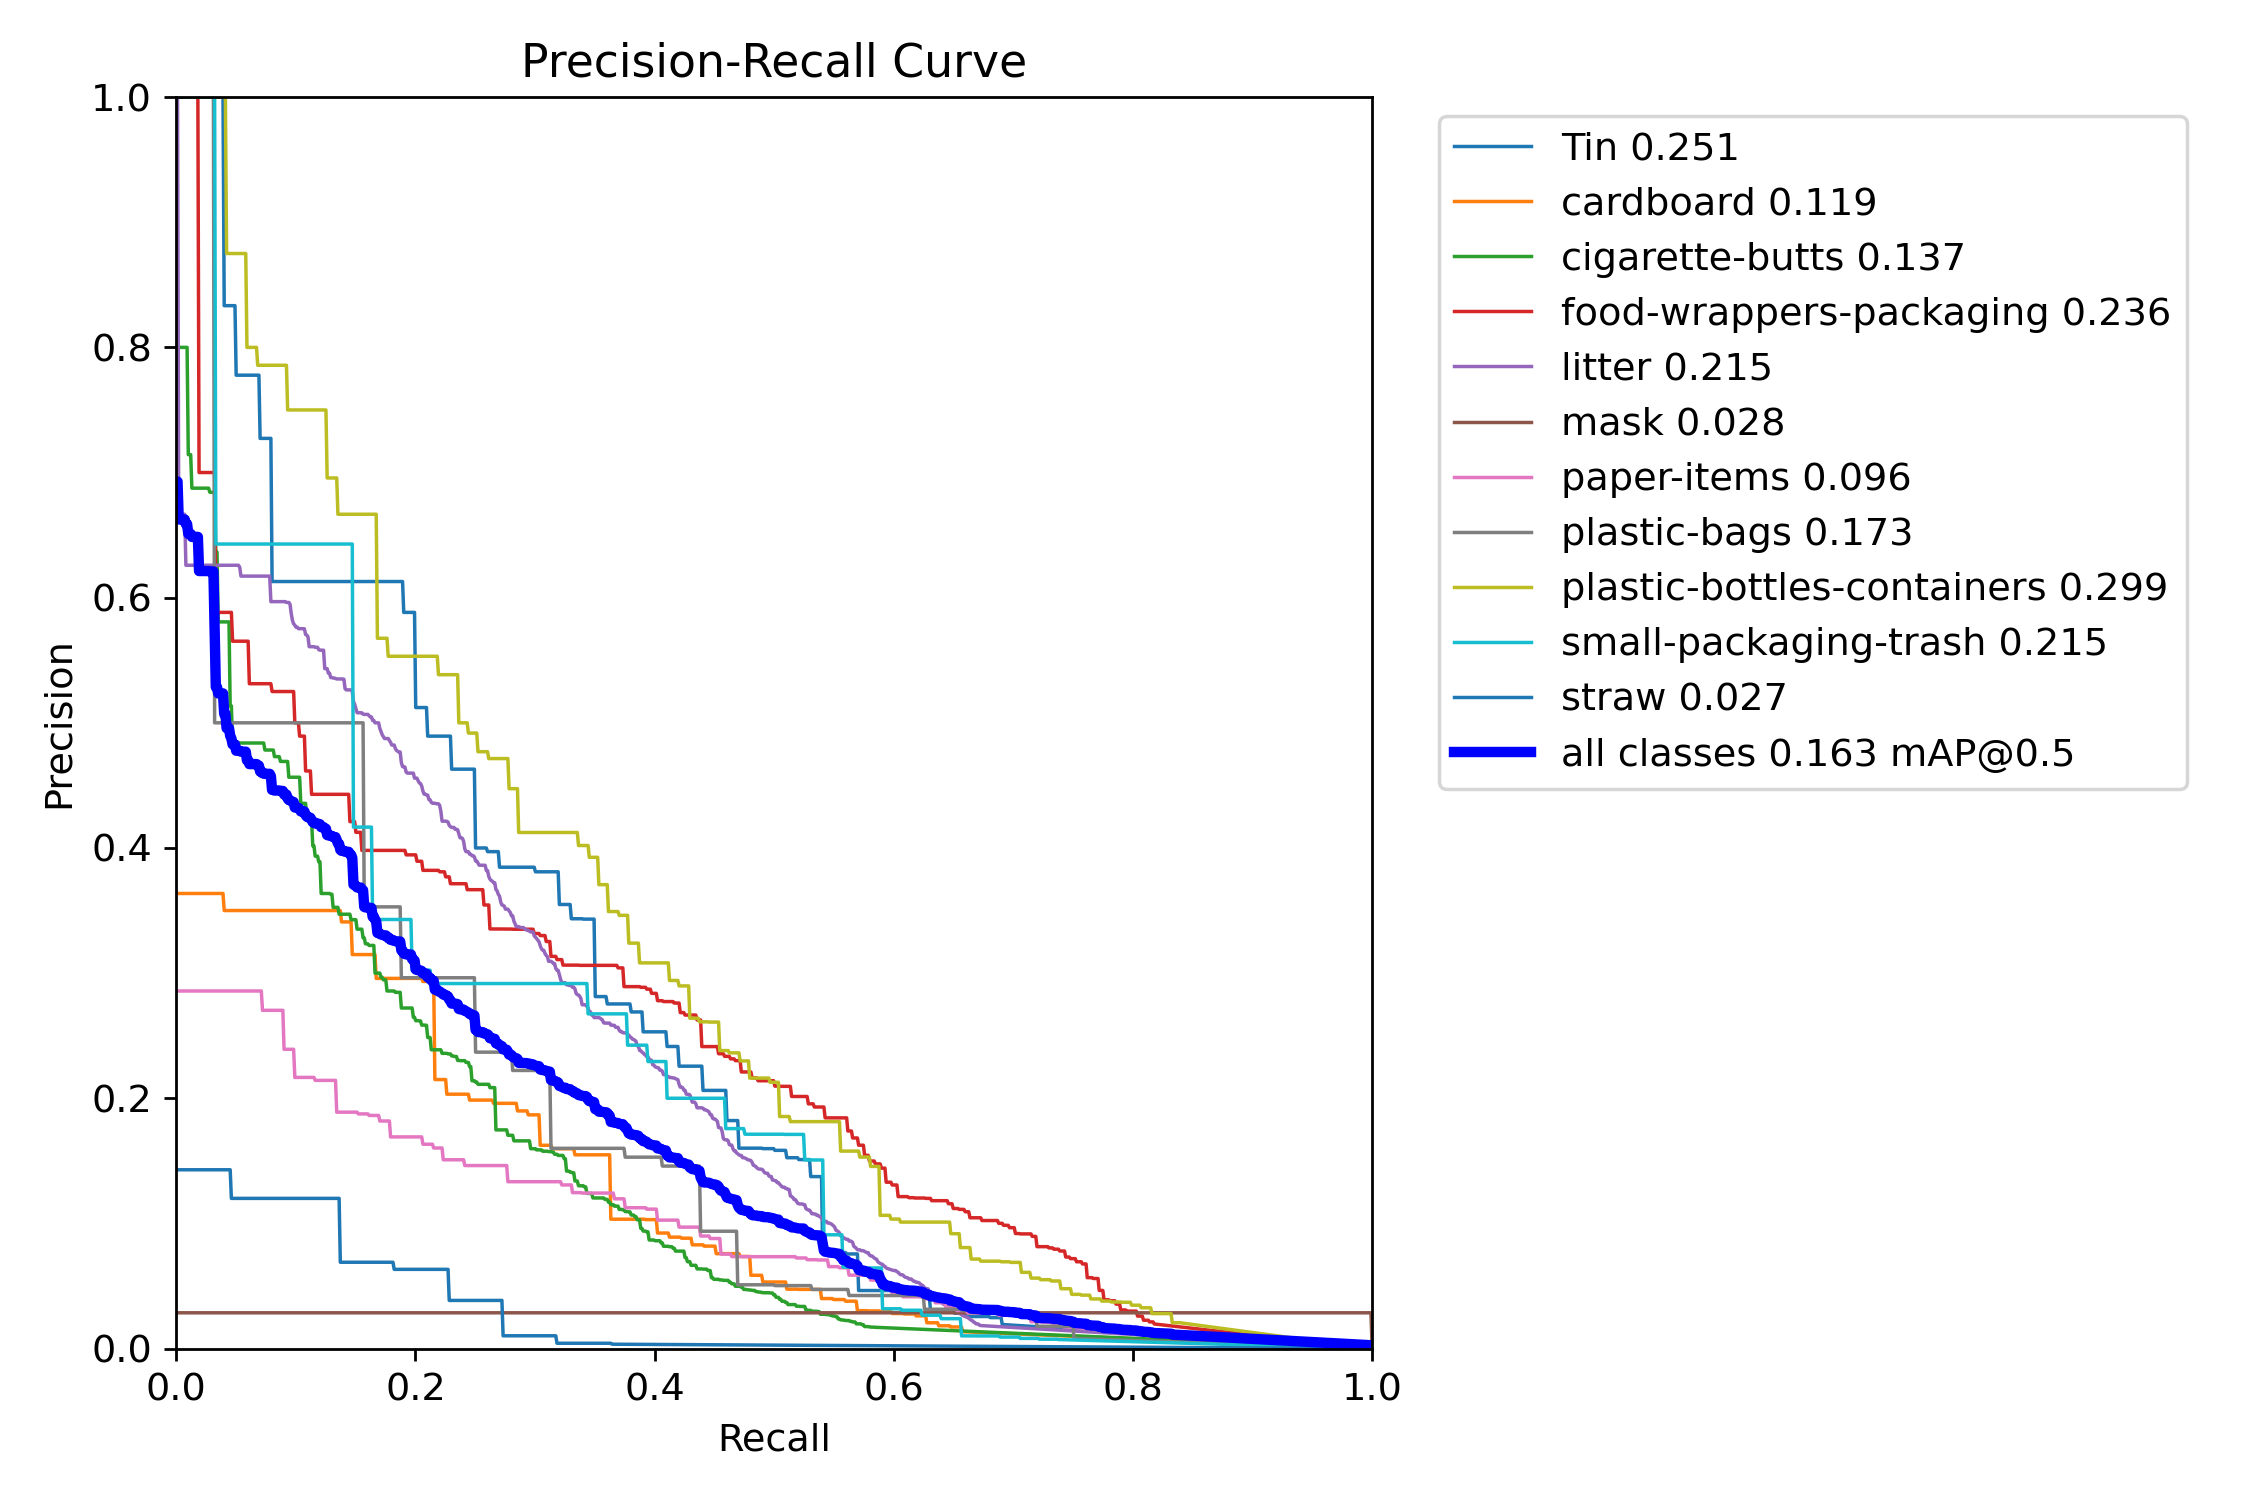

Displaying F1_curve.png


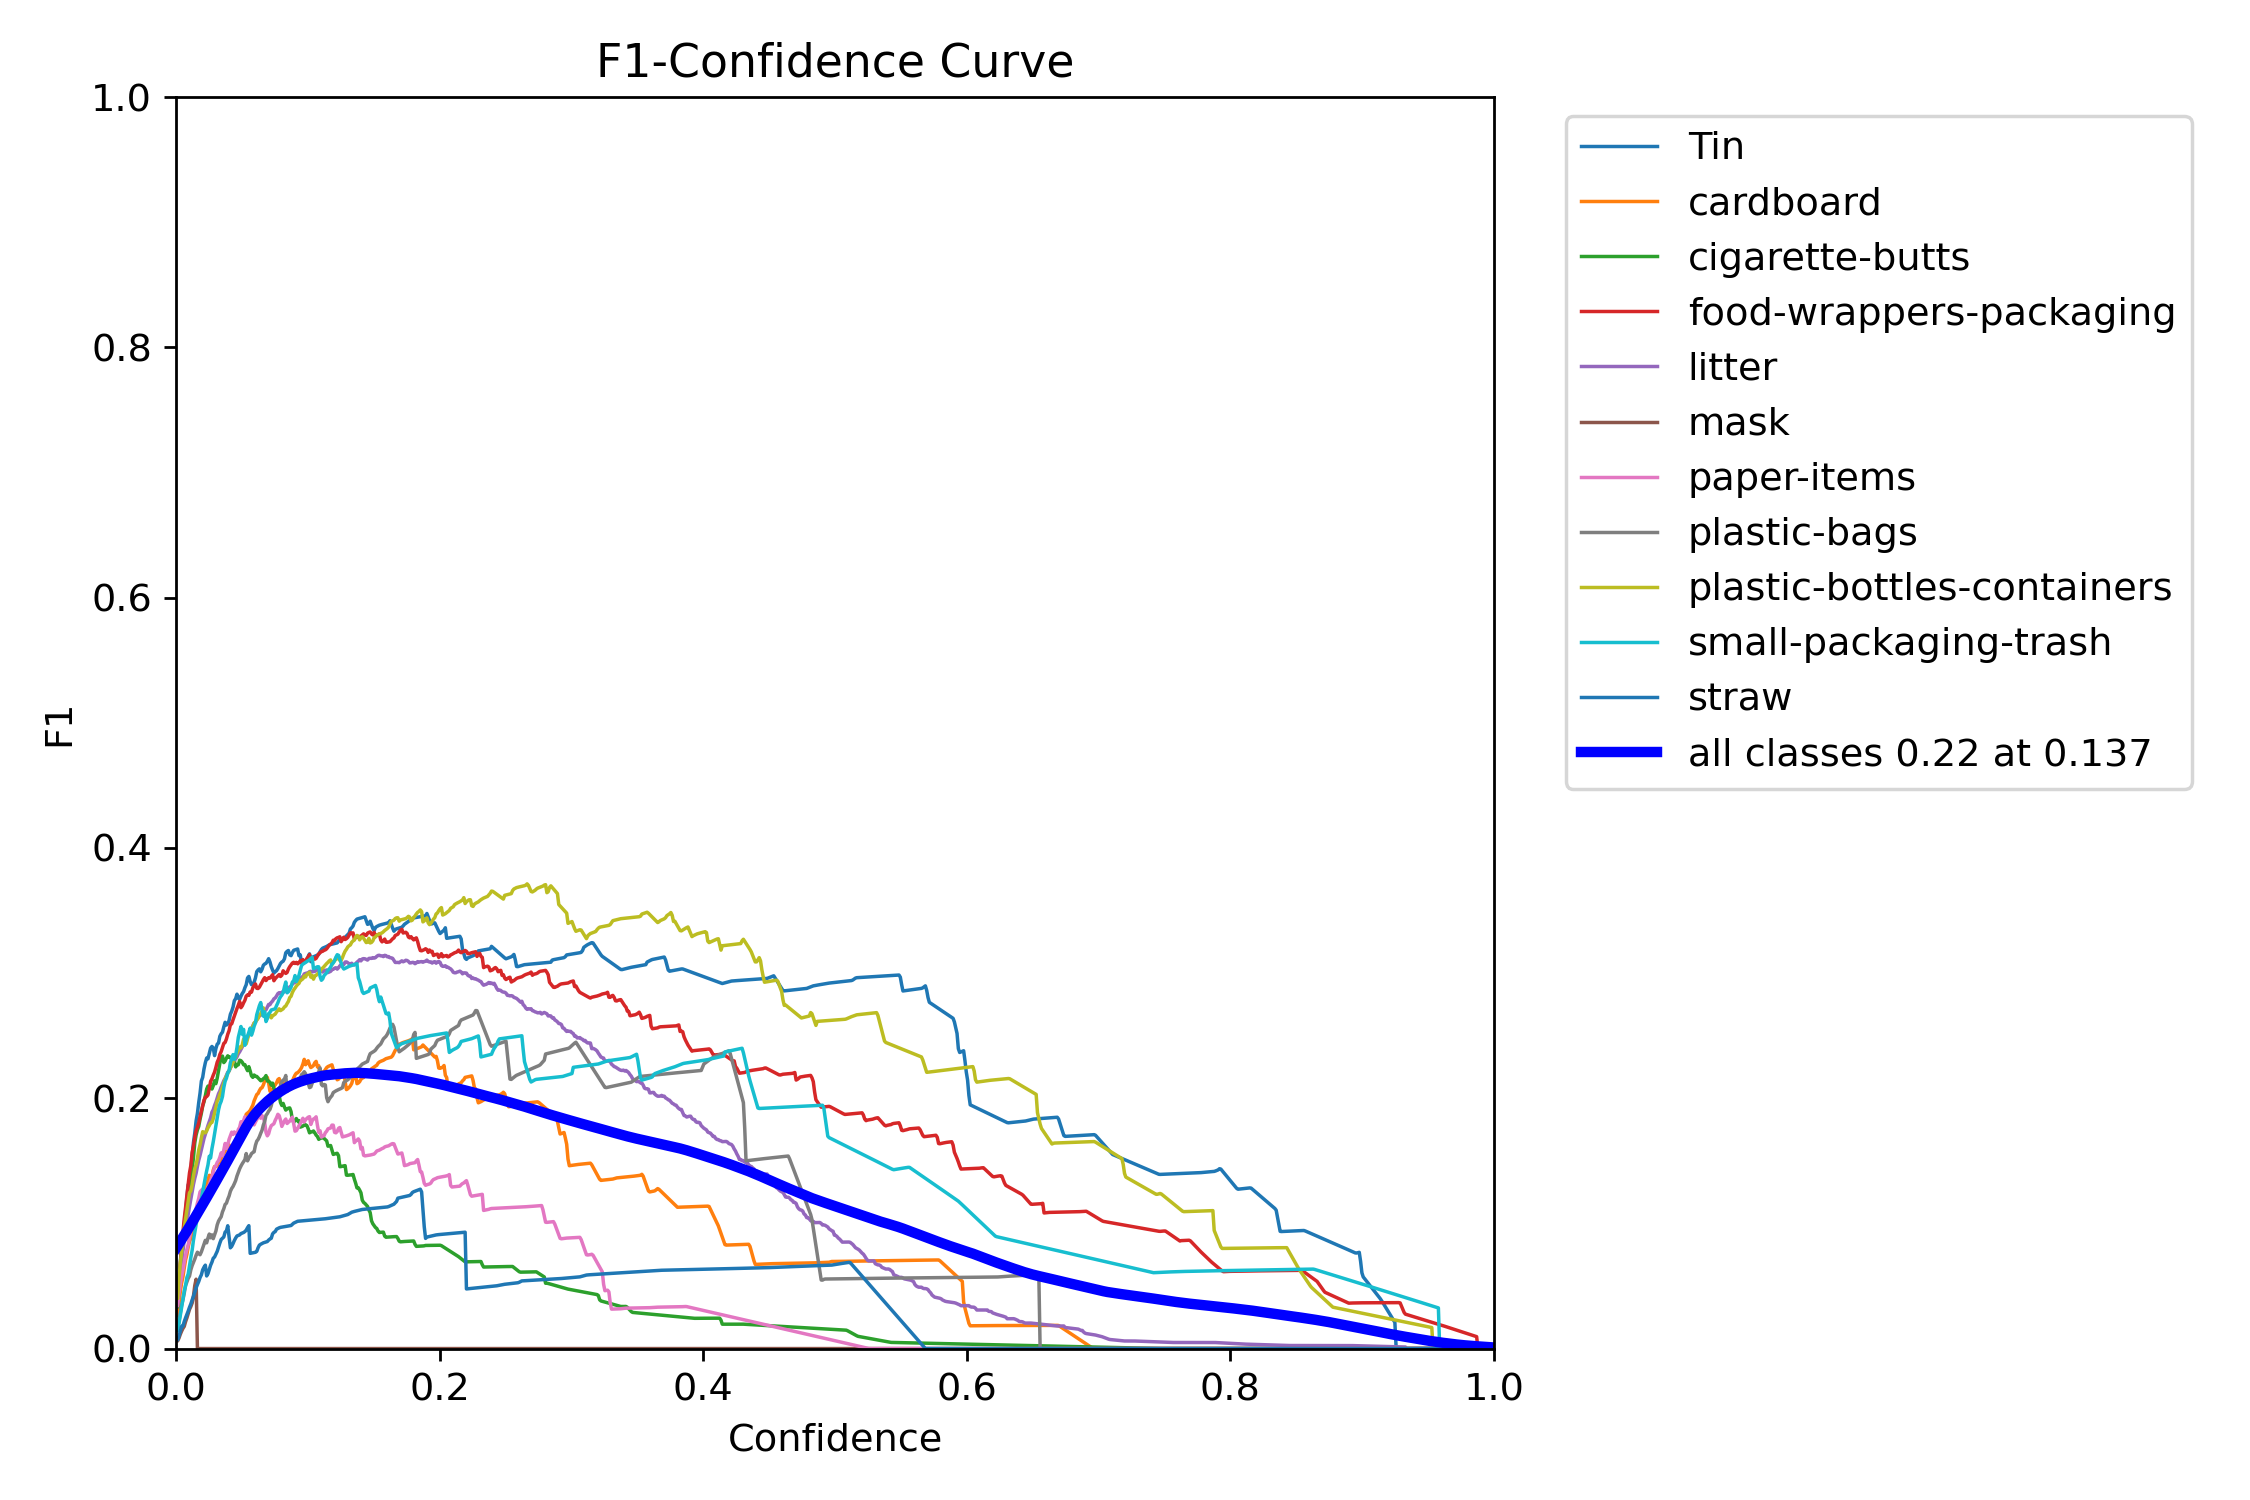


Training and validation complete!

    Enhanced YOLOv12n Model Summary (Non-Replacement Approach)
    ---------------------------------------------------------
    Model name: enhanced_yolov12n
    Classes: 11
    Trained for: 100 epochs
    Final performance:
    - mAP50-95: 0.0943
    - mAP50: 0.1632
    - Precision: 0.3270
    - Recall: 0.2499
    
    Enhancement approach:
    - Original YOLOv12n layers preserved
    - Added CBAM modules at key feature extraction points
    - Added Transformer encoder at deeper feature layers
    - Added Small Object Features enhancement for improved detection of small items
    
    Model saved at: /content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule/enhanced_yolov12n
    


In [ ]:

# =====================================
# PART 4: MAIN EXECUTION
# =====================================

if __name__ == "__main__":
    print("Enhanced YOLOv12n for Trash Detection - Non-Replacement Approach")

    # Define paths
    combined_data_yaml = '/content/drive/MyDrive/SemesterProjectDatas/CombinedData/data.yaml'
    project_dir = '/content/drive/My Drive/SemesterProjectDatas/Model/NewEnhancedYolo12nModule'

    # You can adjust parameters here
    EPOCHS = 100
    BATCH_SIZE = 32
    IMG_SIZE = 640
    MODEL_NAME = 'enhanced_yolov12n'

    # Train enhanced model (without replacing internal layers)
    model, metrics = train_enhanced_yolo(
        data_yaml=combined_data_yaml,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        project_dir=project_dir,
        model_name=MODEL_NAME
    )

    print("\nTraining and validation complete!")

    # Save a summary of the model
    output_summary = f"""
    Enhanced YOLOv12n Model Summary (Non-Replacement Approach)
    ---------------------------------------------------------
    Model name: {MODEL_NAME}
    Classes: {nc}
    Trained for: {EPOCHS} epochs
    Final performance:
    - mAP50-95: {metrics.box.map:.4f}
    - mAP50: {metrics.box.map50:.4f}
    - Precision: {metrics.box.mp:.4f}
    - Recall: {metrics.box.mr:.4f}

    Enhancement approach:
    - Original YOLOv12n layers preserved
    - Added CBAM modules at key feature extraction points
    - Added Transformer encoder at deeper feature layers
    - Added Small Object Features enhancement for improved detection of small items

    Model saved at: {os.path.join(project_dir, MODEL_NAME)}
    """

    print(output_summary)

    with open(os.path.join(project_dir, f'{MODEL_NAME}_summary.txt'), 'w') as f:
        f.write(output_summary)